## Критерий согласия Пирсона (  χ2 )

In [1]:
import numpy as np
from numpy import random
import pandas as pd
from tqdm import tqdm

from scipy import stats
from scipy.stats import norm

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go

import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

import seaborn as sns
%matplotlib inline

init_notebook_mode(connected=True)

### Generate sample from standard normal distribution and plot it

In [2]:
iplot(ff.create_distplot([random.normal(0, 1, 1000)], ['normal distribution'], bin_size=.1))

#### starting with defining split functions

In [3]:
snd = norm()
# N samples of random normal distr
n = 1000

# Optimal Break Points
optimal_bp = [-2.8069, -2.2378, -1.8011, -1.4150, -1.0435, -0.6590, -0.2325, 
                        0.2325, 0.6590, 1.0435, 1.4150, 1.8011, 2.2378, 2.8069]

def get_expected_frequences(snd, n, bp):
    result = []
    result.append(n * snd.cdf(bp[0]))
    for i in range(1, len(bp)):
        result.append(n * (snd.cdf(bp[i]) - snd.cdf(bp[i - 1])))
    result.append(n * snd.sf(bp[-1]))
    return np.array(result)

def get_observed_frequences(input_x, bp):
    a_ = np.mean(input_x)
    sigma_ = np.std(input_x)
    x_normalized = np.array([(i - a_)/sigma_ for i in input_x])
    n = len(x_normalized)
    result = []
    result.append(len(x_normalized[np.where(x_normalized < bp[0])]))
    for i in range(1, len(bp)):
        result.append(len(x_normalized[np.where((x_normalized >= bp[i - 1]) & (x_normalized < bp[i]))]))
    result.append(len(x_normalized[np.where(x_normalized >= bp[-1])]))
    return np.array(result)
    
def get_standard_normal_distr(seed, n):
    return random.RandomState(seed).normal(0, 1, n)

### Looking for the seed that gives p-value closest to 0.05 from upper

100%|██████████| 9999/9999 [00:05<00:00, 1899.02it/s]

p-value closest to target 0.01 = 0.010054802007563379
seed = 5807


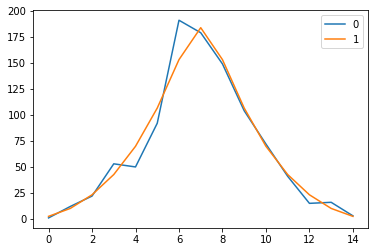

In [4]:
expected_frequences_ = get_expected_frequences(snd, n, optimal_bp)

def find_seed_giving(target_p_value, range_start=1, range_end=10000):
    seed = 0
    lowest_p_diff = 1

    tmp_a = get_standard_normal_distr(seed, n)
    observed_frequences_worst = None

    for i in tqdm(range(range_start, range_end)):
        tmp_a = get_standard_normal_distr(i, n)

        observed_frequences_ = get_observed_frequences(tmp_a, optimal_bp)
        res_tmp = stats.chisquare(observed_frequences_, expected_frequences_, ddof = 1)
        if res_tmp.pvalue < target_p_value:
            continue
        if (res_tmp.pvalue - target_p_value) < lowest_p_diff:
            lowest_p_diff = res_tmp.pvalue - target_p_value
            seed = i
            observed_frequences_worst = observed_frequences_
            
    return seed, lowest_p_diff, observed_frequences_worst

target_p_value = 0.01
seed, lowest_p_diff, observed_frequences_worst = find_seed_giving(target_p_value=target_p_value)
        
print(f'p-value closest to target {target_p_value} = {target_p_value + lowest_p_diff}')
print(f'seed = {seed}')
        
df_ = pd.DataFrame(data=np.hstack((observed_frequences_worst.reshape(-1, 1), 
                                 expected_frequences_.reshape(-1, 1))))
df_.plot()

## Let's reproduce results and compare with not optimal split

In [14]:
test_distr = get_standard_normal_distr(seed, n)

iplot(ff.create_distplot([test_distr], ['test_distr'], bin_size=.1))

In [5]:
expected_frequences = get_expected_frequences(snd, len(test_distr), optimal_bp)
observed_frequences = get_observed_frequences(test_distr, optimal_bp)
print(f'expected_frequences: {expected_frequences}\n'
     f'observed_frequences: {observed_frequences}')

expected_frequences: [  2.50103836  10.11601186  23.22650966  42.69068814  69.82414239
 106.58949392 153.12695928 183.85031279 153.12695928 106.58949392
  69.82414239  42.69068814  23.22650966  10.11601186   2.50103836]
observed_frequences: [  1  12  22  53  50  92 191 179 149 104  72  41  15  16   3]


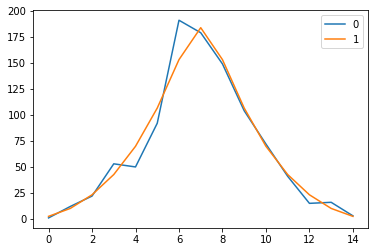

In [6]:
df = pd.DataFrame(data=np.hstack((observed_frequences.reshape(-1, 1), 
                                 expected_frequences.reshape(-1, 1))))
df.plot()

### And now let's check chisquare criteria value for our generated sample

We remember that our test data was generated using np.random.normal.
But what p_value will be returned by stats.chisquare ststistics?

In [7]:
res_optimal = stats.chisquare(observed_frequences, expected_frequences, ddof = 1)
res_optimal

Power_divergenceResult(statistic=27.671134004363946, pvalue=0.010054802007563379)

### Now let's create equal intervals and check chisquare one more time

In [8]:
# NOT Optimal Break Points
equal_bp = [(i - 6.5)/2.5 for i in range(14)]
print(len(equal_bp), equal_bp)

14 [-2.6, -2.2, -1.8, -1.4, -1.0, -0.6, -0.2, 0.2, 0.6, 1.0, 1.4, 1.8, 2.2, 2.6]


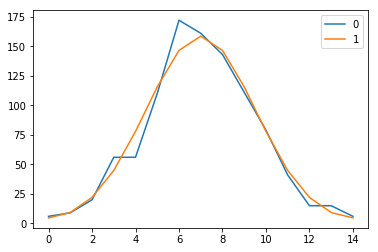

In [9]:
expected_frequences_ = get_expected_frequences(snd, len(test_distr), equal_bp)
observed_frequences_ = get_observed_frequences(test_distr, equal_bp)

df_ = pd.DataFrame(data=np.hstack((observed_frequences_.reshape(-1, 1), 
                                 expected_frequences_.reshape(-1, 1))))
df_.plot()

In [10]:
res_not_optimal = stats.chisquare(observed_frequences_, expected_frequences_, ddof = 1)
res_not_optimal

Power_divergenceResult(statistic=21.093227873530896, pvalue=0.07110503947597863)

In [11]:
f'p-value diff: {res_not_optimal.pvalue - res_optimal.pvalue}'

'p-value diff: 0.061050237468415244'

## We see that p-value differs significantly. This demonstrates an importance of use asymptotically optimal splitting

## Let's now chech the view of QQ-plots for our test_distr, that gives p-value=0.05 when we use asymptotically optimal splitting

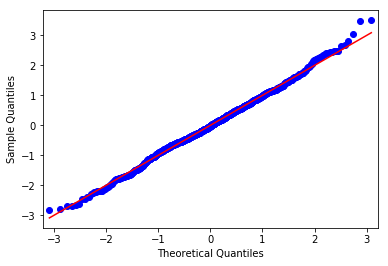

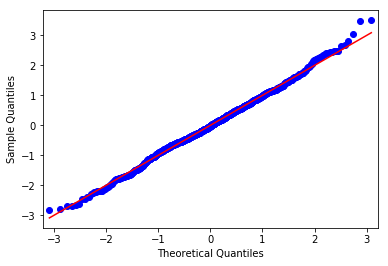

In [12]:
qqplot(test_distr, line='s', fit=True)

100%|██████████| 9999/9999 [00:05<00:00, 1889.64it/s]


p-value closest to target 0.8 = 0.8011735570304552
seed = 6934


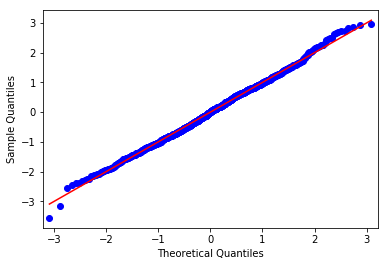

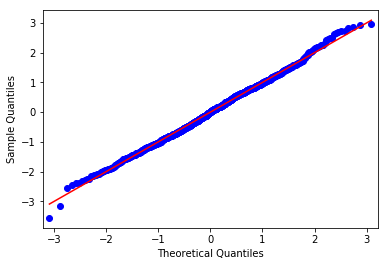

In [13]:
target_p_value80 = 0.8
seed_p80, p_diff = find_seed_giving(target_p_value=target_p_value80)[:2]
print(f'p-value closest to target {target_p_value80} = {target_p_value80 + p_diff}')
print(f'seed = {seed_p80}')

qqplot(get_standard_normal_distr(seed=seed_p80, n=n), line='s', fit=True)